In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np
import os
from scipy.stats import qmc
pd.set_option('display.max_rows', 500) 
import shutil
import netCDF4 as nc4
import sys
sys.path.append("/glade/u/home/adamhb/california-fates/ensemble_tools/")
import modp as mp
from scipy.io import netcdf as nc
import re

## Specify paths and load emulator

In [9]:
path_to_base_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25'
#path_to_base_param_files_root = '/home/adam/cloud/gdrive/postdoc/parameters'

path_to_ensemble_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/'
#path_to_ensemble_param_files_root = '/home/adam/cloud/gdrive/postdoc/parameters/test_ensemble'

path_to_ca_fates = '/glade/u/home/adamhb/california-fates/'
path_to_esm_tools = '/glade/u/home/adamhb/Earth-System-Model-Tools/'

# The parameter file used for parameter values that don't vary in the ensemble 
base_param_file_name = 'ca_ahb_5pfts_092123.nc'

# New param file name prefix for the parameter files that do vary
file_name_prefix = 'ca_5pfts_100523'

# Instances per case
inst_per_case = 128

# Cases
n_cases = 10

target_ensemble_size = inst_per_case * n_cases

# Prefix for subdirectories where param files for the ensemble are kept
param_files_subdir_prefix = f'ca_5pfts_ml_assisted_{target_ensemble_size}_040523'

path_DNN_NFailed_PFTs = os.path.join(path_to_ca_fates,'ml_emulators/saved_models/DNN_NFailed_110323_v1.h5')
DNN_NFailed_PFTs = keras.models.load_model(path_DNN_NFailed_PFTs)
#DNN_NFailed_PFTs = tf.keras.models.load_model(path_DNN_NFailed_PFTs)

path_to_ensemble_data =os.path.join(path_to_ca_fates,'ml_emulators/ML_training_data_110323.csv')

# Path to parameter ranges
param_ranges_full = pd.read_csv(os.path.join(path_to_ca_fates,'parameter_ranges/param_range_archive/param_ranges_040524.csv'))

# How large should each lhs sample be in the generator
batch_size = 1000
starting_seed = 17

## Check that saved model is working

pick up here

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3708 entries, 0 to 3707
Columns: 120 entries, Unnamed: 0.1 to param_file_path
dtypes: float64(114), int64(4), object(2)
memory usage: 3.4+ MB


['Unnamed: 0', 'BA', 'AGB', 'TreeStemD', 'ResproutD_oak', 'ResproutD_shrub', 'ShannonE', 'NPP', 'FailedPFTs', 'Pct_shrub_cover_canopy', 'Pct_shrub_cover', 'Combustible_fuel', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_shrub', 'BA_oak', 'inst', 'fates_recruit_seed_alloc_mature_1', 'fates_recruit_seed_alloc_mature_2', 'fates_recruit_seed_alloc_mature_3', 'fates_recruit_seed_alloc_mature_4', 'fates_recruit_seed_alloc_mature_5', 'fates_recruit_seed_dbh_repro_threshold_1', 'fates_recruit_seed_dbh_repro_threshold_2', 'fates_recruit_seed_dbh_repro_threshold_3', 'fates_recruit_seed_dbh_repro_threshold_5', 'fates_fire_alpha_SH_1', 'fates_fire_alpha_SH_2', 'fates_fire_alpha_SH_3', 'fates_fire_alpha_SH_4', 'fates_fire_alpha_SH_5', 'fates_fire_bark_scaler_1', 'fates_fire_bark_scaler_2', 'fates_fire_bark_scaler_3'

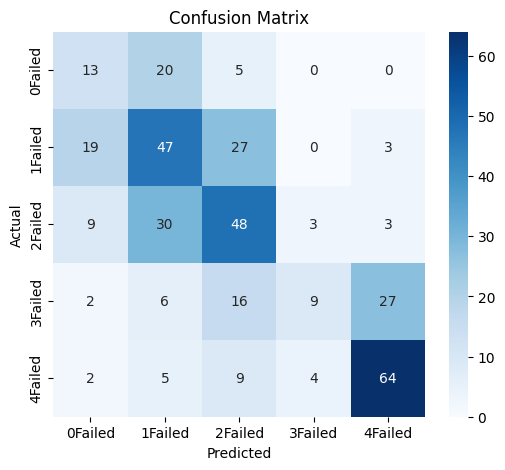

              precision    recall  f1-score   support

     0Failed       0.29      0.34      0.31        38
     1Failed       0.44      0.49      0.46        96
     2Failed       0.46      0.52      0.48        93
     3Failed       0.56      0.15      0.24        60
     4Failed       0.66      0.76      0.71        84

    accuracy                           0.49       371
   macro avg       0.48      0.45      0.44       371
weighted avg       0.50      0.49      0.47       371



In [10]:
raw_df = pd.read_csv(path_to_ensemble_data)
raw_df.info()
print("\n")

# Drop first column
raw_df.drop(columns=raw_df.columns[0], axis=1, inplace=True)
print(list(raw_df.columns))

df = raw_df.copy()
df.fillna(0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['FailedPFTs']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_y_failedPFTs = test_set["FailedPFTs"].copy()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# This is for if I need to define a custom data transformation function
from sklearn.base import BaseEstimator, TransformerMixin

# Data transformation pipeline
transformation_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # Scale the data by substracting mean and dividing by sigma
    ])

# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)

# Apply to test data
X_test = transformation_pipeline.fit_transform(test_X)


from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


loss, accuracy = DNN_NFailed_PFTs.evaluate(X_test, test_y_failedPFTs)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

probabilities = DNN_NFailed_PFTs.predict(X_test)
y_pred = np.argmax(probabilities, axis=1)
print(y_pred)

target_names = [str(i) + "Failed" for i in range(5)]

# Compute the confusion matrix
cm = confusion_matrix(test_y_failedPFTs, y_pred)

# Display the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Optionally, display the classification report for more detailed metrics
print(classification_report(test_y_failedPFTs, y_pred, target_names= target_names))

## Load parameter ranges

In [11]:
pft_names = ['pine','cedar','fir','shrub','oak']

param_ranges_full = param_ranges_full[['pft_ineq','param', 'value_min', 'value_max', 'pft', 'organ']]

# Define params that we are going to sample from the LHS
param_ranges = param_ranges_full.loc[param_ranges_full['pft_ineq'] == 'FALSE']

# Defin params that we are going to alter using pft-inequalities
param_ranges_inequalities = param_ranges_full.loc[param_ranges_full['pft_ineq'] != 'FALSE']

# Make sure min and max are floats
convert_dict = {'value_min': float,
                'value_max': float
                }
param_ranges = param_ranges.astype(convert_dict)

# number of parameters
n_params = len(param_ranges)
print("Number of params:",n_params)

# number of PFTs - some are global so subtract one
n_pfts = max(len(pd.unique(param_ranges['pft'])) - 1, 1)
print("Number of pfts:", n_pfts)

param_names = list(param_ranges.param)
print("Param names:",param_names)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)

param_ranges.info()

Number of params: 63
Number of pfts: 5
Param names: ['fates_recruit_seed_alloc_mature', 'fates_recruit_seed_alloc_mature', 'fates_recruit_seed_alloc_mature', 'fates_recruit_seed_dbh_repro_threshold', 'fates_recruit_seed_dbh_repro_threshold', 'fates_fire_alpha_SH', 'fates_fire_alpha_SH', 'fates_fire_alpha_SH', 'fates_fire_bark_scaler', 'fates_fire_bark_scaler', 'fates_fire_bark_scaler', 'fates_fire_crown_kill', 'fates_fire_crown_kill', 'fates_fire_crown_kill', 'fates_fire_drying_ratio', 'fates_fire_nignitions', 'fates_fire_threshold', 'fates_mort_bmort', 'fates_mort_bmort', 'fates_mort_bmort', 'fates_leaf_slatop', 'fates_leaf_slatop', 'fates_leaf_slatop', 'fates_leaf_vcmax25top', 'fates_leaf_vcmax25top', 'fates_leaf_vcmax25top', 'fates_mort_scalar_cstarvation', 'fates_mort_scalar_cstarvation', 'fates_mort_scalar_cstarvation', 'fates_fire_frac_resprout', 'fates_fire_frac_resprout', 'fates_frag_seed_decay_rate', 'fates_frag_seed_decay_rate', 'fates_frag_seed_decay_rate', 'fates_recruit_se

## Functions

In [12]:
def contains_angle_brackets(s):
    return '<' in s or '>' in s

def get_param_value_from_ineq(ref_pft_value,min_val,max_val,pft_ineq):
    '''returns the parameter value for the pft that depends on a reference pft value'''
    
    if contains_angle_brackets(pft_ineq):
        if ">" in pft_ineq:
            min_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
        if "<" in pft_ineq:
            max_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
    else:
        new_value = ref_pft_value
    
    return new_value

def find_duplicates(lst):
    count = {}
    duplicates = []

    for item in lst:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1

    for key, value in count.items():
        if value > 1:
            duplicates.append(key)

    return duplicates

def remove_duplicates(lst):
    no_duplicates = []
    [no_duplicates.append(x) for x in lst if x not in no_duplicates]
    return no_duplicates

def add_pft_nums(input_string,numbers):
    return [input_string + "_{}".format(i) for i in numbers]

def add_param_names_for_writing_to_netcdf():
    
    '''It needs to have all the variable names and indices required to write a netcdf file with the parameter values

    The variable names and indices required to write the netcdf file are contained in the column headers, but there are some exceptions:

    * fates_leaf_slamax_{1:5} equals fates_leaf_sla25top{1:5}
    * fates_allom_d2ca_coefficient_min_{1:5} equals fates_allom_d2ca_coefficient_max_{1:5}
    * fates_frag_maxdecomp_{2,3,5} are calcuated as specific fractions of fates_frag_maxdecomp_1
    * fates_mort_hf_sm_threshold_{1:5} are the same as fates_mort_hf_sm_threshold_0
    * fates_recruit_inter_patch_disp_frac_{1:5} are same as fates_recruit_inter_patch_disp_frac_0

    '''
     
    # These are added so that when we write to netcdf files we can just use the column headers as a guide for
    # param name and index
    
    # add fates_leaf_slamax_{1:5} 
    slamax = add_pft_nums("fates_leaf_slamax",[1,2,3,4,5])
    
    # add fates_allom_d2ca_coefficient_min_{1:5}
    allom_d2ca = add_pft_nums("fates_allom_d2ca_coefficient_min",[1,2,3,4,5])
    
    # add fates_frag_maxdecomp_{2,3,5}
    maxdecomp = add_pft_nums("fates_frag_maxdecomp",[2,3,5])
    
    # add fates_mort_hf_sm_threshold_{1:5}
    hf = add_pft_nums("fates_mort_hf_sm_threshold",[1,2,3,4,5])
    
    # add fates_recruit_inter_patch_disp_frac_{1:5}
    disp = add_pft_nums("fates_recruit_inter_patch_disp_frac",[1,2,3,4,5])
    
    return slamax + allom_d2ca + maxdecomp + hf + disp

def generate_lhs_df(batch_size, seed, param_ranges):

    sampler = qmc.LatinHypercube(d=n_params, seed=seed)
    sample = sampler.random(n=batch_size)

    # scale to parameter ranges
    l_bounds = param_ranges['value_min']
    u_bounds = param_ranges['value_max']

    scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

    print("ensemble dimensions:",scaled_sample.shape)

    # Create a dataframe of the LHS ensemble
    col_names = [v + "_" + str(p) for v,p in zip(param_names,pfts)]
    lhs_df = pd.DataFrame(data=scaled_sample,columns=col_names)
    
    return lhs_df


def add_inequality_cols(lhs_df,param_ranges_inequalities):

    # Create column names of the inequalities parameters
    col_names_inequalities = [v + "_" + str(p) for v,p in zip(param_ranges_inequalities["param"],param_ranges_inequalities['pft'])]

    # Add columns names for special cases
    col_names_inequalities = col_names_inequalities + add_param_names_for_writing_to_netcdf()

    col_names_inequalities = remove_duplicates(col_names_inequalities)
    
    def remove_element(lst, element_to_remove):
        return [item for item in lst if item != element_to_remove]
 
    col_names_inequalities = remove_element(col_names_inequalities, "fates_frag_maxdecomp_0")
    
    inequalities_df = pd.DataFrame(np.zeros((lhs_df.shape[0],len(col_names_inequalities))),columns=col_names_inequalities)

    # Concatenate the dfs
    df = pd.concat([lhs_df,inequalities_df], axis = 1)

    return df

def get_ref_pft_num(ineq):  
    for p in pft_names:
        if p in ineq:
            return pft_names.index(p) + 1
        
def generate_parameter_values_for_inequalities(param_ranges_inequalities,df):
    
    print("Adding pft inequalities...")
    
    for ensemble_member_row in df.index:
    
        for i in param_ranges_inequalities.index:

            # input data from the inequalities df
            d = param_ranges_inequalities.loc[i]

            # Make sla max the same as slatop
            if d['param'] == "fates_leaf_slamax":
                for i in range(1,6):
                    pft_to_assign_value_to = i
                    reference_col = "fates_leaf_slatop_" + str(pft_to_assign_value_to)
                    target_col = "fates_leaf_slamax_" + str(pft_to_assign_value_to)
                    reference_val = df.loc[ensemble_member_row,reference_col]
                    target_val = reference_val
                    df.at[ensemble_member_row,target_col] = target_val
                    if i == 1:
                        df.at[ensemble_member_row,"fates_leaf_slamax_0"] = target_val

            # Make d2camin the same as d2ca max
            if d['param'] == "fates_allom_d2ca_coefficient_min":
                for i in range(1,6):
                    pft_to_assign_value_to = i
                    reference_col = "fates_allom_d2ca_coefficient_max_" + str(pft_to_assign_value_to)
                    target_col = "fates_allom_d2ca_coefficient_min_" + str(pft_to_assign_value_to)
                    reference_val = df.loc[ensemble_member_row,reference_col]
                    target_val = reference_val
                    df.at[ensemble_member_row,target_col] = target_val
                    if i == 1:
                        df.at[ensemble_member_row,"fates_allom_d2ca_coefficient_min_0"] = target_val

            # Calculate fates_frag_maxdecomp
            if d['param'] == "fates_frag_maxdecomp":
                col_name_suffix = d['organ']
                reference_col = "fates_frag_maxdecomp_0"
                target_col = "fates_frag_maxdecomp_" + str(int(col_name_suffix))

                reference_val = df.loc[ensemble_member_row,reference_col]

                target_val = reference_val * d['value_max']

                df.at[ensemble_member_row,target_col] = target_val

            # Set fates_mort_hf_sm_threshold the same for all pfts
            for i in range(1,6):
                pft_to_assign_value_to = i
                reference_col = "fates_mort_hf_sm_threshold_0"
                target_col = "fates_mort_hf_sm_threshold_" + str(int(pft_to_assign_value_to))

                reference_val = df.loc[ensemble_member_row,reference_col]

                target_val = reference_val

                df.at[ensemble_member_row,target_col] = target_val

            # Set fates_mort_hf_sm_threshold the same for all pfts
            for i in range(1,6):
                pft_to_assign_value_to = i
                reference_col = "fates_recruit_inter_patch_disp_frac_0"
                target_col = "fates_recruit_inter_patch_disp_frac_" + str(int(pft_to_assign_value_to))
                reference_val = df.loc[ensemble_member_row,reference_col]
                target_val = reference_val
                df.at[ensemble_member_row,target_col] = target_val
            
            # Set the inequalities
            if get_ref_pft_num(d['pft_ineq']) is not None:
                pft_to_assign_value_to = d["pft"]
                reference_pft_num = get_ref_pft_num(d['pft_ineq'])
                reference_col = d['param'] + "_" + str(int(reference_pft_num))
                reference_val = df.loc[ensemble_member_row,reference_col]
                target_col = d['param'] + "_" + str(int(pft_to_assign_value_to))
                target_val = get_param_value_from_ineq(reference_val,min_val = d['value_min'],
                                                       max_val = d['value_max'],pft_ineq = d['pft_ineq'])
                df.at[ensemble_member_row,target_col] = target_val
                
    print("Finished adding pft inequalities!")
            

def check_na_and_zeros(df):
    # Check for NA values in each column
    na_count = df.isna().sum()
    print("NA counts in each column:")
    print(na_count)

    # Check for zeros in each column
    zero_count = (df == 0).sum()
    print("\nZero counts in each column:")
    print(zero_count)
    
    

def get_substring_before_underscore(s):
    match = re.search(r'^(.*?)_(?=\d)', s)
    return match.group(1) if match else None

def get_last_number(s):
    matches = re.findall(r'\d+', s)
    return int(matches[-1]) if matches else None

def assign_var_to_nc(file,var_name,value,index):
    
    '''
    assigns a value to a netcdf for a particular pft and organ
    
    file = full path to netcdf
    var_name = fates parameter name
    value = parameter value to add to file
    '''
    
    # open nc file
    ncfile = nc.netcdf_file(file, 'a')
    
    # define param of interest
    var = ncfile.variables[var_name]
    
    # get number of dimensions
    ndim = len(var.dimensions)
    
    if var_name == "fates_stoich_nitr":
        organ_index = 0
        var[organ_index,index] = value
    
    elif "fates_leafage_class" in var.dimensions:
        var[:,index] = value
   
    elif ndim == 0:
        
        var[...] = value
    
    else:
        var[index] = value

## Generate promising ensemble memebers


Make sure I can turn this off

In [6]:
df_promising = pd.DataFrame()

while len(df_promising) < target_ensemble_size:
    
    if len(df_promising) == 0:
        seed = starting_seed
    else:
        seed = seed + 1
    
    print("LHS seed:",seed)
    
    # Create df of potentail paramterizations
    lhs_df = generate_lhs_df(batch_size, seed, param_ranges)
    df = add_inequality_cols(lhs_df,param_ranges_inequalities)
    generate_parameter_values_for_inequalities(param_ranges_inequalities,df)

    # Check which ones will work
    X = transformation_pipeline.fit_transform(df[X_cols])
    probabilities = DNN_NFailed_PFTs.predict(X)
    y_pred = np.argmax(probabilities, axis=1)
    y_pred_0 = [i == 0 for i in y_pred]
    df_promising = pd.concat([df_promising,df[y_pred_0]])
    
    print(len(df_promising), "promising ensemble members so far...")
    df_promising_reset = df_promising.reset_index()

LHS seed: 16
ensemble dimensions: (1000, 63)
Adding pft inequalities...
Finished adding pft inequalities!
32/32 [==============================] - 0s 811us/step
68 promising ensemble members so far...
LHS seed: 17
ensemble dimensions: (1000, 63)
Adding pft inequalities...
Finished adding pft inequalities!
32/32 [==============================] - 0s 790us/step
127 promising ensemble members so far...
LHS seed: 18
ensemble dimensions: (1000, 63)
Adding pft inequalities...
Finished adding pft inequalities!
32/32 [==============================] - 0s 777us/step
182 promising ensemble members so far...
LHS seed: 19
ensemble dimensions: (1000, 63)
Adding pft inequalities...
Finished adding pft inequalities!
32/32 [==============================] - 0s 783us/step
236 promising ensemble members so far...
LHS seed: 20
ensemble dimensions: (1000, 63)
Adding pft inequalities...
Finished adding pft inequalities!
32/32 [==============================] - 0s 777us/step
283 promising ensemble members s

## Make subdirectories for parameter files

In [7]:
param_file_subdirs = []
for subdir_i in range(n_cases):
    subdir_tag = str(subdir_i+1).rjust(2, '0')
    param_file_subdirs.append(param_files_subdir_prefix +"_" + subdir_tag)
print(param_file_subdirs)

for i in range(len(param_file_subdirs)):
    os.makedirs(os.path.join(path_to_ensemble_param_files_root,param_file_subdirs[i]),exist_ok=True)

['ca_5pfts_ml_assisted_2160_110323_01', 'ca_5pfts_ml_assisted_2160_110323_02', 'ca_5pfts_ml_assisted_2160_110323_03', 'ca_5pfts_ml_assisted_2160_110323_04', 'ca_5pfts_ml_assisted_2160_110323_05', 'ca_5pfts_ml_assisted_2160_110323_06', 'ca_5pfts_ml_assisted_2160_110323_07', 'ca_5pfts_ml_assisted_2160_110323_08', 'ca_5pfts_ml_assisted_2160_110323_09', 'ca_5pfts_ml_assisted_2160_110323_10', 'ca_5pfts_ml_assisted_2160_110323_11', 'ca_5pfts_ml_assisted_2160_110323_12', 'ca_5pfts_ml_assisted_2160_110323_13', 'ca_5pfts_ml_assisted_2160_110323_14', 'ca_5pfts_ml_assisted_2160_110323_15', 'ca_5pfts_ml_assisted_2160_110323_16', 'ca_5pfts_ml_assisted_2160_110323_17', 'ca_5pfts_ml_assisted_2160_110323_18', 'ca_5pfts_ml_assisted_2160_110323_19', 'ca_5pfts_ml_assisted_2160_110323_20']


## Write promising parameterizations to netcdf files

In [8]:
## Read in FATES file with values that will be used for all non-varying parameters

# This parameter file has many changes associated with it compared to the default FATES file
# It also has new parameter added as part of the development required for this experiment.
input_fname = os.path.join(path_to_base_param_files_root,base_param_file_name)

print(input_fname)

# for each sample
row = -1

for subdir in param_file_subdirs:
    
    print("Working on",subdir)
    
    for i in range(0,inst_per_case) :
        
        row = row + 1
                
        param_file_end = str(i+1).rjust(4, '0')

        # final parameter file name
        new_file_name = file_name_prefix + '_{0}.nc'.format(param_file_end)
        fout = os.path.join(path_to_ensemble_param_files_root,subdir,new_file_name)

        shutil.copyfile(input_fname, fout)                                                                                                                             
      
        # loop through each parameter and apply either to the correct pft or globally
        for col_name in sorted(list(df_promising.columns)): 
           
            var_name = get_substring_before_underscore(col_name)
            
            index = max(0,get_last_number(col_name) - 1)
            value = df_promising_reset.loc[row, col_name]
            #print("col_name",col_name)
            #print("var_name",var_name)
            #print("index",index)
            #print("value",value)
            assign_var_to_nc(fout,var_name,value,index)

/glade/u/home/adamhb/ahb_params/fates_api_25/ca_ahb_5pfts_092123.nc
Working on ca_5pfts_ml_assisted_2160_110323_01


/glade/scratch/adamhb/ipykernel_43425/2875880961.py:238: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  ncfile = nc.netcdf_file(file, 'a')


Working on ca_5pfts_ml_assisted_2160_110323_02
Working on ca_5pfts_ml_assisted_2160_110323_03
Working on ca_5pfts_ml_assisted_2160_110323_04
Working on ca_5pfts_ml_assisted_2160_110323_05
Working on ca_5pfts_ml_assisted_2160_110323_06
Working on ca_5pfts_ml_assisted_2160_110323_07
Working on ca_5pfts_ml_assisted_2160_110323_08
Working on ca_5pfts_ml_assisted_2160_110323_09
Working on ca_5pfts_ml_assisted_2160_110323_10
Working on ca_5pfts_ml_assisted_2160_110323_11
Working on ca_5pfts_ml_assisted_2160_110323_12
Working on ca_5pfts_ml_assisted_2160_110323_13
Working on ca_5pfts_ml_assisted_2160_110323_14
Working on ca_5pfts_ml_assisted_2160_110323_15
Working on ca_5pfts_ml_assisted_2160_110323_16
Working on ca_5pfts_ml_assisted_2160_110323_17
Working on ca_5pfts_ml_assisted_2160_110323_18
Working on ca_5pfts_ml_assisted_2160_110323_19
Working on ca_5pfts_ml_assisted_2160_110323_20
